# Model development

## Setup

In [1]:
!pip install -r ../requirements.txt

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm # DO NOT REMOVE

from typing import List

%matplotlib inline

In [3]:
CSV_PATH = "../data/gym_members_exercise_tracking.csv"
df = pd.read_csv(CSV_PATH)

In [4]:
import sys
sys.path.append("..")

In [5]:
from libs.setup import Run

run = Run(Path.joinpath(Path.cwd().parent, "runs")).initialize()

run.add_raw(df, filename="gym_members_exercise_tracking")

WindowsPath('c:/Users/drwni/Desktop/MEINF/AI/WP_01/runs/2024-12-14 22-24-20/data/raw/gym_members_exercise_tracking')

In [6]:
from sklearn.preprocessing import OneHotEncoder

_encoder = OneHotEncoder()
_encoded_categorical = pd.DataFrame(
    _encoder.fit_transform(df.select_dtypes(include=['object'])).toarray(), 
    columns=_encoder.get_feature_names_out(df.select_dtypes(include=['object']).columns),
)

encoded_df = df.drop(columns=df.select_dtypes(include=['object']).columns)
encoded_df = pd.concat([encoded_df, _encoded_categorical], axis=1)
encoded_df.head()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Gender_Female,Gender_Male,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
0,56,88.3,1.71,180,157,60,1.69,1313.0,12.6,3.5,4,3,30.20,0.0,1.0,0.0,0.0,0.0,1.0
1,46,74.9,1.53,179,151,66,1.30,883.0,33.9,2.1,4,2,32.00,1.0,0.0,0.0,1.0,0.0,0.0
2,32,68.1,1.66,167,122,54,1.11,677.0,33.4,2.3,4,2,24.71,1.0,0.0,1.0,0.0,0.0,0.0
3,25,53.2,1.70,190,164,56,0.59,532.0,28.8,2.1,3,1,18.41,0.0,1.0,0.0,0.0,1.0,0.0
4,38,46.1,1.79,188,158,68,0.64,556.0,29.2,2.8,3,1,14.39,0.0,1.0,0.0,0.0,1.0,0.0


In [7]:
from sklearn.model_selection import train_test_split

TARGET = "Calories_Burned"
TEST_SIZE = 0.2
RANDOM_STATE = 42

X = encoded_df.drop(columns=[TARGET])
y = encoded_df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(778, 18) (778,)
(195, 18) (195,)


## Model Selection

In [30]:
# The metrics we will use to evaluate and compare the models
from sklearn.metrics import r2_score, root_mean_squared_error

# Basic preprocessing for testing
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

# The models we will train with
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# For saving the models
from joblib import dump
from datetime import timedelta, datetime
import humanize


models = [
    LinearRegression, 
    Lasso, 
    Ridge, 
    DecisionTreeRegressor, 
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    SVR, 
    MLPRegressor,
]

pipelines = []

for model in models:
    pipelines.append(Pipeline([
        ('scaler', StandardScaler()), 
        ('model', model())
    ]))

In [31]:
pipelines

[Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())]),
 Pipeline(steps=[('scaler', StandardScaler()), ('model', Lasso())]),
 Pipeline(steps=[('scaler', StandardScaler()), ('model', Ridge())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', DecisionTreeRegressor())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', RandomForestRegressor())]),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', GradientBoostingRegressor())]),
 Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR())]),
 Pipeline(steps=[('scaler', StandardScaler()), ('model', MLPRegressor())])]

## Training and Validation

## Model Training

In [34]:
def model_training(
    pipelines: List[Pipeline],
    # model_names: List[any],
    X_train: pd.DataFrame, 
    y_train: pd.Series,
) -> dict[str, Pipeline]:
    """Trains the models in the pipelines list and returns a dictionary of the trained models.

    Args:
        pipelines (List[Pipeline]): pipelines to train with.
        X_train (pd.DataFrame): Features to train with.
        y_train (pd.Series): Target variable to train with.

    Returns:
        dict[str, Pipeline]: dictionary of trained models.
    """

    models = {}
    train_results = pd.DataFrame(columns=["Model Name", "Training Time", "File Size"])

    # Train models
    for num, pipeline in enumerate(pipelines, start=1):
        model_name = pipeline.named_steps["model"].__class__.__name__.lower()

        t_start = datetime.now()
        
        models[model_name] = pipeline.fit(X_train, y_train)

        duration = str((datetime.now() - t_start).seconds)

        # model_name = model_names[num - 1].__name__.lower()
        model_path =  Path.joinpath(run.paths.models, f"{model_name}.joblib")

        dump(pipeline, model_path, compress=True)

        # Track file size
        bytes_size = os.path.getsize(model_path)
        size = humanize.naturalsize(bytes_size)

        train_results.loc[model_name] = [model_name, duration, size]
        run.logger.info(f"(%02i/%02i) Finished training {model_name} in {duration}", num, len(pipelines))

    # Save train results to file
    train_results.to_csv(run.paths.base / "train_results.csv")
    
    return models

In [36]:
models = model_training(pipelines, X_train, y_train)
models.keys()

22:30:54 - INFO - (01/08) Finished training linearregression in 0
22:30:54 - INFO - (02/08) Finished training lasso in 0
22:30:54 - INFO - (03/08) Finished training ridge in 0
22:30:54 - INFO - (04/08) Finished training decisiontreeregressor in 0
22:30:55 - INFO - (05/08) Finished training randomforestregressor in 0
22:30:55 - INFO - (06/08) Finished training gradientboostingregressor in 0
22:30:55 - INFO - (07/08) Finished training svr in 0
22:30:56 - INFO - (08/08) Finished training mlpregressor in 0


c:\Users\drwni\Desktop\MEINF\AI\WP_01\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


dict_keys(['linearregression', 'lasso', 'ridge', 'decisiontreeregressor', 'randomforestregressor', 'gradientboostingregressor', 'svr', 'mlpregressor'])

### Model Evaluation

In [39]:
metrics = {
    "R2 Score": r2_score,
    "RMSE": root_mean_squared_error,
}

scores = {}

for name, metric in metrics.items():
    run.logger.info(f"Calculating {name} for each model")
    scores[name] = {}
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        score = metric(y_test, y_pred)
        scores[name][model_name] = score
        run.logger.info(f"{model_name} {name}: {score}")
    

22:37:54 - INFO - Calculating R2 Score for each model
22:37:54 - INFO - linearregression R2 Score: 0.9802675995368527
22:37:54 - INFO - lasso R2 Score: 0.980297089067681
22:37:54 - INFO - ridge R2 Score: 0.9801988816370579
22:37:54 - INFO - decisiontreeregressor R2 Score: 0.9469980722749368
22:37:54 - INFO - randomforestregressor R2 Score: 0.971777323431203
22:37:54 - INFO - gradientboostingregressor R2 Score: 0.9942168837021715
22:37:54 - INFO - svr R2 Score: 0.13393774567823458
22:37:54 - INFO - mlpregressor R2 Score: -3.8697551084677224
22:37:54 - INFO - Calculating RMSE for each model
22:37:54 - INFO - linearregression RMSE: 40.573094713085986
22:37:54 - INFO - lasso RMSE: 40.54276568922698
22:37:54 - INFO - ridge RMSE: 40.64368102361582
22:37:54 - INFO - decisiontreeregressor RMSE: 66.49576813216898
22:37:54 - INFO - randomforestregressor RMSE: 48.5229586526858
22:37:54 - INFO - gradientboostingregressor RMSE: 21.964895297528145
22:37:54 - INFO - svr RMSE: 268.79595564948096
22:37

In [60]:
scores_df = pd.DataFrame(scores)
scores_df

,R2 Score,RMSE
linearregression,0.980268,40.573095
lasso,0.980297,40.542766
ridge,0.980199,40.643681
decisiontreeregressor,0.946998,66.495768
randomforestregressor,0.971777,48.522959
gradientboostingregressor,0.994217,21.964895
svr,0.133938,268.795956
mlpregressor,-3.869755,637.384848


In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
def plot_scores(scores_df: pd.DataFrame):
    """Plots the scores of the models.

    Args:
        scores_df (pd.DataFrame): DataFrame containing the scores.
    """
    
    fig = plt.figure(figsize=(12, 6))

    # Show RMSE and R2 Score as barplots
    fig.suptitle("Model Performance")
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.add_subplot(1, 2, 1)
    sns.barplot(x=scores_df.index, y=scores_df["RMSE"])
    plt.title("RMSE")
    plt.xticks(rotation=90)
    plt.ylabel("RMSE")

    fig.add_subplot(1, 2, 2)
    sns.barplot(x=scores_df.index, y=scores_df["R2 Score"])
    plt.title("R2 Score")
    plt.xticks(rotation=90)
    plt.ylabel("R2 Score")

    plt.show()

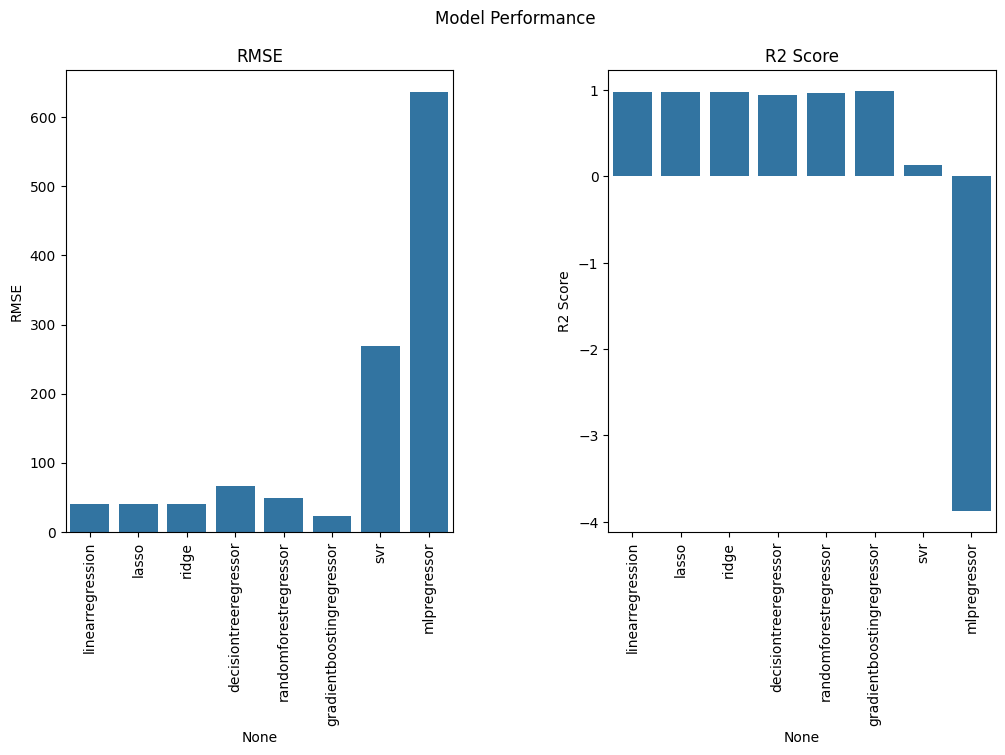

In [69]:
plot_scores(scores_df)

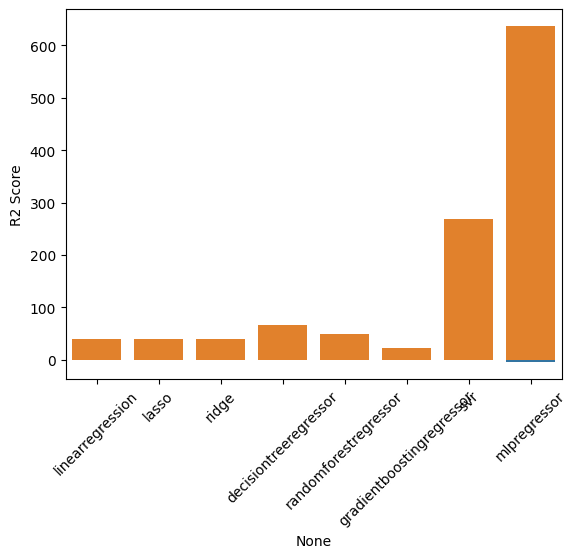

In [70]:
sns.barplot(data=scores_df, x=scores_df.index, y="R2 Score")
sns.barplot(data=scores_df, x=scores_df.index, y="RMSE")

plt.xticks(rotation=45)
plt.show()

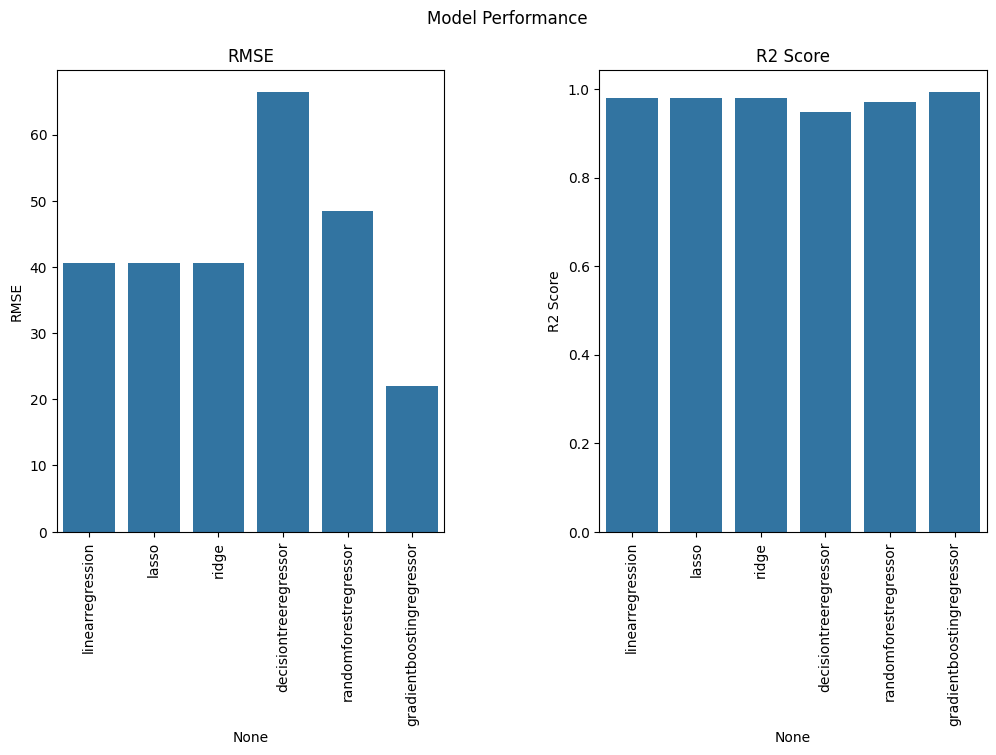

In [71]:
_scores_df = scores_df.copy()
_scores_df.drop(index=["mlpregressor"], inplace=True)
_scores_df.drop(index=["svr"], inplace=True)

plot_scores(_scores_df)